In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import yfinance as yf
import pyfolio as pf

Importando el esquema de optimización

In [2]:
import bollinger as bl

Importación de datos

In [3]:
activos = ['DIS']
fechas = ['2010-11-20', '2020-11-20']
stock = pd.DataFrame()
for activo in activos:
    stock[activo] = yf.Ticker(activo).history(period='1d', start=fechas[0], end=fechas[1])['Close']
stock

,DIS
Date,
2010-11-22,32.184544
2010-11-23,31.461592
2010-11-24,32.114853
2010-11-26,31.966799
2010-11-29,31.722900
...,...
2020-11-13,138.360001
2020-11-16,144.669998
2020-11-17,144.500000


In [4]:
Initial_Date = pd.to_datetime('2012-01-01')

Tuning_dates = [Initial_Date]
curr_month = Initial_Date.month

the_start = np.where(Initial_Date <= stock.index)[0].tolist()[0]

for i in range((the_start+1), len(stock.index)):
    if stock.index[i].month != curr_month:
        Tuning_dates.append(stock.index[i-1])
        curr_month = stock.index[i].month

com = 0.0015
BidAskSpread = 0.00016

In [5]:
Tuning_dates

[Timestamp('2012-01-01 00:00:00'),
 Timestamp('2012-01-31 00:00:00'),
 Timestamp('2012-02-29 00:00:00'),
 Timestamp('2012-03-30 00:00:00'),
 Timestamp('2012-04-30 00:00:00'),
 Timestamp('2012-05-31 00:00:00'),
 Timestamp('2012-06-29 00:00:00'),
 Timestamp('2012-07-31 00:00:00'),
 Timestamp('2012-08-31 00:00:00'),
 Timestamp('2012-09-28 00:00:00'),
 Timestamp('2012-10-31 00:00:00'),
 Timestamp('2012-11-30 00:00:00'),
 Timestamp('2012-12-31 00:00:00'),
 Timestamp('2013-01-31 00:00:00'),
 Timestamp('2013-02-28 00:00:00'),
 Timestamp('2013-03-28 00:00:00'),
 Timestamp('2013-04-30 00:00:00'),
 Timestamp('2013-05-31 00:00:00'),
 Timestamp('2013-06-28 00:00:00'),
 Timestamp('2013-07-31 00:00:00'),
 Timestamp('2013-08-30 00:00:00'),
 Timestamp('2013-09-30 00:00:00'),
 Timestamp('2013-10-31 00:00:00'),
 Timestamp('2013-11-29 00:00:00'),
 Timestamp('2013-12-31 00:00:00'),
 Timestamp('2014-01-31 00:00:00'),
 Timestamp('2014-02-28 00:00:00'),
 Timestamp('2014-03-31 00:00:00'),
 Timestamp('2014-04-

In [6]:
log_ret = np.log(stock/stock.shift(1))
retornos = np.zeros(len(stock.index)-the_start)

bl.stock=stock.iloc[:the_start+1,:]


Parametros = bl.GA(10,10,7,0.05)

In [9]:
log_ret = np.log(stock/stock.shift(1))
retornos = np.zeros(len(stock.index)-the_start)

bl.stock=stock.iloc[:the_start+1,:]


Parametros = bl.GA(10,10,7,0.05)
Media,desvest = Parametros['best_config']

BB = bl.decision(prices=stock, periodos_media=Media, no_desv= desvest)
log_ret = np.log(stock/stock.shift(1)).shift(-1)
tabla=pd.DataFrame({'Precios':stock.iloc[Media:,0],
                    'Rend':log_ret.iloc[Media:,0],
                    'Señales':BB[0],
                    'Media':BB[1],
                    'Inferior':BB[2],
                    'Superior':BB[3]})
       
aux = 0

for i in range((the_start+1), len(stock.index)):
    if stock.index[i] in Tuning_dates:
                
        fecha_index = np.where(stock.index[i] == stock.index)[0].tolist()[0]
        fecha_tabla = np.where(stock.index[i] == tabla.index)[0].tolist()[0]
        retornos[aux] = tabla['Rend'][fecha_tabla]*tabla['Señales'][fecha_tabla]
        
        bl.stock=stock.iloc[:fecha_index+1,:]

        Parametros = bl.GA(10,10,7,0.05)
        Media,desvest = Parametros['best_config']
        
        BB = bl.decision(prices=stock,
                         periodos_media = Media,
                         no_desv = desvest)
        log_ret = np.log(stock/stock.shift(1)).shift(-1)
        tabla=pd.DataFrame({'Precios':stock.iloc[Media:,0],
                            'Rend':log_ret.iloc[Media:,0],
                            'Señales':BB[0],
                            'Media':BB[1],
                            'Inferior':BB[2],
                            'Superior':BB[3]})        
        aux += 1
    else:
        fecha_tabla = np.where(stock.index[i] == tabla.index)[0].tolist()[0]
        retornos[aux] = tabla['Rend'][fecha_tabla]*tabla['Señales'][fecha_tabla]
        aux += 1

Start date,2012-01-03
End date,2020-11-19
Total months,106
,Backtest
Annual return,-14.5%
Cumulative returns,-75.2%
Annual volatility,23.9%
Sharpe ratio,-0.54
Calmar ratio,-0.18
Stability,0.81
Max drawdown,-82.0%


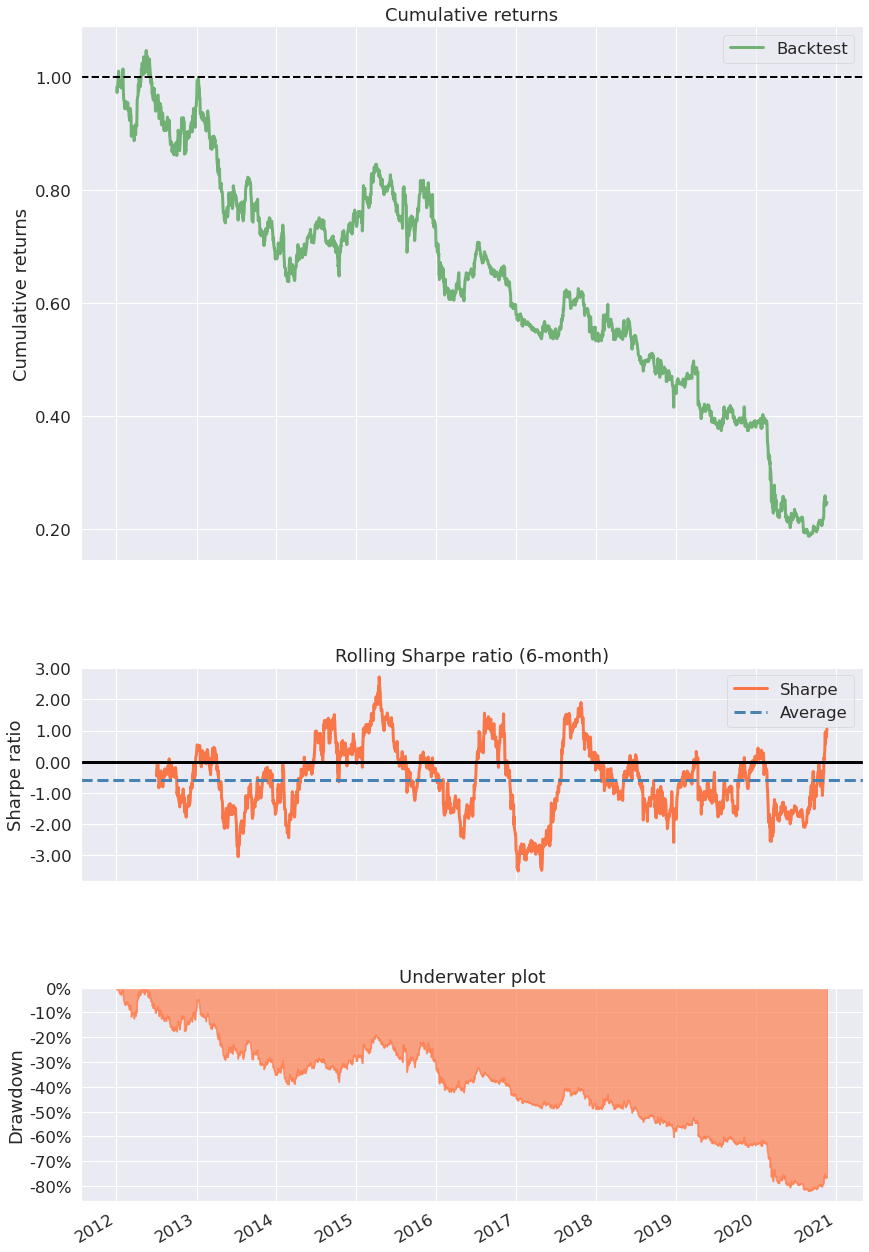

In [10]:
Retornos = pd.Series(retornos, index = stock.index[the_start:])
Retornos = Retornos.fillna(value = 0)
Retornos.columns = ['Retornos']

pf.create_simple_tear_sheet(Retornos)